
# Limpeza e Preparação da Série Temporal
Este notebook executa os 5 passos solicitados:
1. Preencher ausências com estratégia configurável.
2. Marcar feriados automaticamente.
3. Remover/corrigir outliers.
4. Separar almoço e jantar.
5. Gerar gráficos de inspeção.


In [9]:

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt

df = pd.read_csv('../data/raw/comensais22-24-clean.csv', parse_dates=['Data'])
df = df.sort_values('Data')
df.set_index('Data', inplace=True)

df.head()


,Comensais_almoço,Comensais_janta
Data,,
2022-03-16,315.0,100.0
2022-03-17,220.0,110.0
2022-03-18,350.0,120.0
2022-03-19,NaN,NaN
2022-03-20,NaN,NaN


In [10]:

# Estratégia: forward fill + média móvel como fallback
df_filled = df.copy()
df_filled = df_filled.fillna(method='ffill').fillna(df_filled.rolling(window=7, min_periods=1).mean())
df_filled.head()


C:\Users\michelly\AppData\Local\Temp\ipykernel_2448\3158269849.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_filled.fillna(method='ffill').fillna(df_filled.rolling(window=7, min_periods=1).mean())


,Comensais_almoço,Comensais_janta
Data,,
2022-03-16,315.0,100.0
2022-03-17,220.0,110.0
2022-03-18,350.0,120.0
2022-03-19,350.0,120.0
2022-03-20,350.0,120.0


In [11]:

import holidays
br_holidays = holidays.Brazil()

df_filled['feriado'] = df_filled.index.map(lambda d: 1 if d in br_holidays else 0)
df_filled.head()


,Comensais_almoço,Comensais_janta,feriado
Data,,,
2022-03-16,315.0,100.0,0
2022-03-17,220.0,110.0,0
2022-03-18,350.0,120.0,0
2022-03-19,350.0,120.0,0
2022-03-20,350.0,120.0,0


In [12]:

# Correção de outliers usando IQR por coluna
df_out = df_filled.copy()
for col in df_out.columns:
    if col != 'feriado':
        q1 = df_out[col].quantile(0.25)
        q3 = df_out[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr
        df_out[col] = df_out[col].clip(lower, upper)

df_out.head()


,Comensais_almoço,Comensais_janta,feriado
Data,,,
2022-03-16,315.0,100.0,0
2022-03-17,220.0,110.0,0
2022-03-18,350.0,120.0,0
2022-03-19,350.0,120.0,0
2022-03-20,350.0,120.0,0


In [13]:
df_lunch = df_out[['Comensais_almoço', 'feriado']].copy()
df_dinner = df_out[['Comensais_janta', 'feriado']].copy()


df_lunch.head(), df_dinner.head()


(            Comensais_almoço  feriado
 Data                                 
 2022-03-16             315.0        0
 2022-03-17             220.0        0
 2022-03-18             350.0        0
 2022-03-19             350.0        0
 2022-03-20             350.0        0,
             Comensais_janta  feriado
 Data                                
 2022-03-16            100.0        0
 2022-03-17            110.0        0
 2022-03-18            120.0        0
 2022-03-19            120.0        0
 2022-03-20            120.0        0)

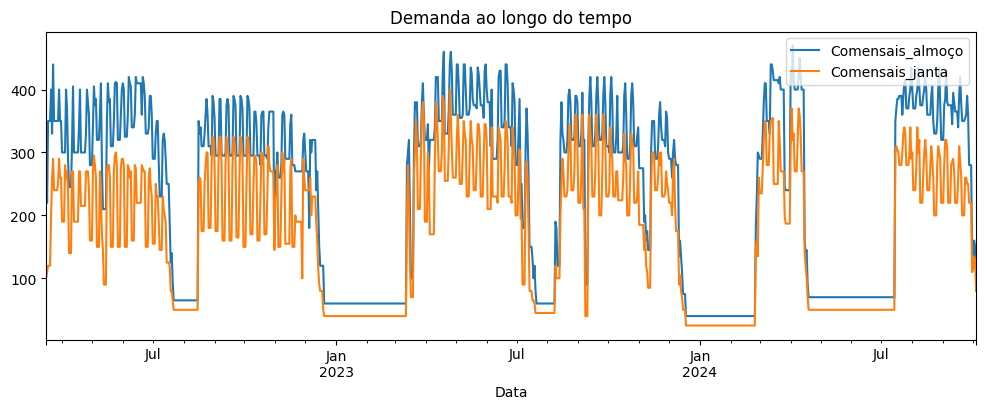

In [15]:

df_out[['Comensais_almoço','Comensais_janta']].plot(figsize=(12,4))
plt.title('Demanda ao longo do tempo')
plt.show()
